In [8]:
# general
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pytimeparse.timeparse import timeparse

# sklearn
from sklearn.metrics import (
    accuracy_score
)

# bootstrapped
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

sns.set()

In [2]:
def plot_accuracy_distribution(control_group, test_group, test_group_name, bins=30):
    plt.figure(figsize=(10, 6))
    bins = np.linspace(
        df_user_error['accuracy'].min(),
        df_user_error['accuracy'].max(),
        bins
    )

    plt.hist(control_group, bins=bins, label="No feedback (control group)", alpha=0.5)
    plt.hist(test_group, bins=bins, label=f"{test_group_name} (test group)", color='orange', alpha=0.5)
    plt.title('Comperation of accuracy distribution')
    plt.legend()
    

def get_confidence_intervals(test_group, control_group):
    ab = bs.bootstrap_ab(np.array(test_group), np.array(control_group), bs_stats.mean, bs_compare.percent_change)
    return ab.value, ab.lower_bound, ab.upper_bound

# 1. General statistics
## 1.1. Read data

In [9]:
METRICS = ["accuracy"]
TEST_GROUP_NAMES = ['high quality feedback']

In [10]:
df = pd.read_csv('../../data/synonyms/synonyms-dataset.csv')
df['annotation__time'] = df['annotation__time'].apply(timeparse)

## 1.2. Statistics
### 1.2.1. General

In [11]:
pd.DataFrame([
    {
        "metric": "total_annotations",
        "value": len(df)
    },
    {
        "metric": "unique_items",
        "value": len(set(df['data__item_id'].values))
    },
    {
        "metric": "unique_users",
        "value": len(set(df['user__id'].values))
    },
    {
        "metric": "total_annotation_time",
        "value": time.strftime('%Hh %Mm %Ss', time.gmtime(df['annotation__time'].sum()))
    },
]).set_index("metric")
    

,value
metric,
total_annotations,6598
unique_items,1950
unique_users,128
total_annotation_time,22h 38m 23s


### 1.2.2. Annotations per item

In [12]:
pd.DataFrame(df['item_id'].value_counts().describe())

,item_id
count,1950.000000
mean,3.383590
std,0.966625
min,2.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,7.000000


### 1.2.3. Annotations per user

In [13]:
pd.DataFrame(df['user__id'].value_counts().describe())

,user__id
count,128.000000
mean,51.546875
std,25.840473
min,11.000000
25%,50.000000
50%,50.000000
75%,50.000000
max,300.000000


## 1.3. Compute user's annotation quality metrics
- In this section we aggregate the raw result to compute the quality metrics value per user
- To measure the quality of user's annotation we use: accuracy
- Mean error is computed for each user in each test_group separately.<br/>
This way we can check how each user did in each test conditions

In [5]:
data = []
for (test_group, user_feedback, user_id), group in df.groupby(['test_group', 'user__feedback', 'user__id']):
    y_true = group['reference__output']
    y_pred = group['annotation__output']

    data.append({
        'test_group': test_group,
        'user__feedback': user_feedback,
        'user__id': user_id,
        'count': len(group),
        'accuracy': accuracy_score(y_true, y_pred)
    })

df_user_error = pd.DataFrame(data)

In [6]:
pd.merge(
    df_user_error,
    df_user_error.groupby(
        ['test_group', 'user__feedback']
    )['user__id'].count().to_frame('users_count'),
    on=['test_group', 'user__feedback']
).groupby(
    ['test_group', 'user__feedback', 'users_count']
)[METRICS].aggregate(['mean', 'std'])

accuracy          
                                                      mean       std
test_group            user__feedback users_count                    
high quality feedback False          54           0.560347  0.132909
                      True           74           0.594302  0.133975

## 1.4. Accuracy distribution for control group and high quality feedback test group
Below you can see a plot showing a accuracy distribution difference for the control group and the test group with the high quality feedback
### 1.4.1. Histogram

In [7]:
test_group_name = "high quality feedback"

control_group = df_user_error[
    (df_user_error['test_group'] == "high quality feedback") &
    (df_user_error['user__feedback'] == False)
]['accuracy']
    
test_group = df_user_error[
    (df_user_error['test_group'] == test_group_name) &
    (df_user_error['user__feedback'] == True)
]['accuracy']

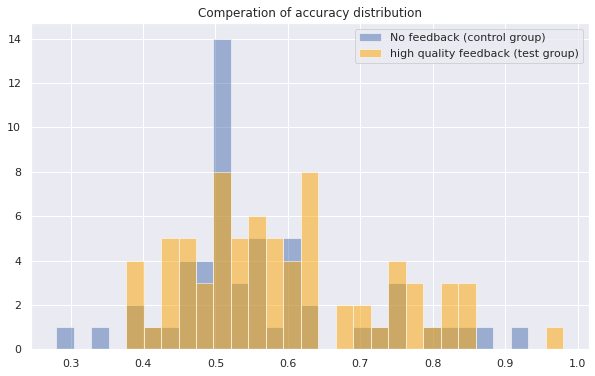

In [24]:
plot_accuracy_distribution(control_group, test_group, test_group_name)

### 1.4.2. Boxplot

In [25]:
_df = df_user_error.copy()
_df.loc[_df['user__feedback'] == False, 'test_group'] = "control group"

<AxesSubplot:title={'center':'Distribution of accuracy metric between test groups'}, xlabel='test_group', ylabel='accuracy'>

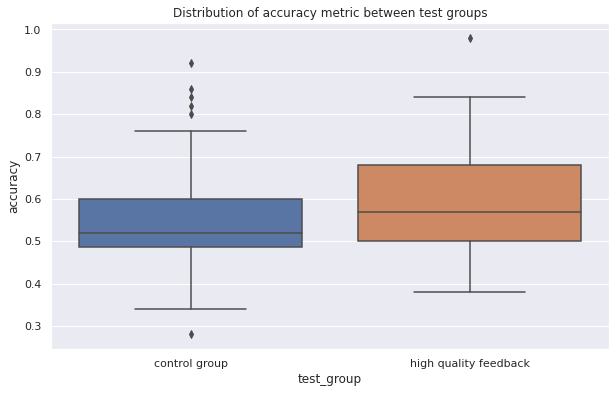

In [26]:
plt.figure(figsize=(10, 6))
plt.title("Distribution of accuracy metric between test groups")
sns.boxplot(x='test_group', y='accuracy', data=_df, order=["control group"] + TEST_GROUP_NAMES)

# 2. Confidence intervals
## 2.1. Compute confidence intervals for test groups
In this section we compute the confidence intervals for the percentage quality change between the control group and each of the test groups.

In [20]:
data = []

for metric in METRICS:
    
    control_group = df_user_error[
        (df_user_error['test_group'] == "high quality feedback") &
        (df_user_error['user__feedback'] == False)
    ][metric]
    
    for test_group_name in TEST_GROUP_NAMES:
        test_group = df_user_error[
            (df_user_error['test_group'] == test_group_name) &
            (df_user_error['user__feedback'] == True)
        ][metric]
        mean, lower_bound, upper_bound = get_confidence_intervals(test_group, control_group)

        data.append({
            "test_group_name": test_group_name,
            "metric": metric,
            "lower_bound": lower_bound,
            "mean": mean,
            "upper_bound": upper_bound
        })

pd.DataFrame(data)

,test_group_name,metric,lower_bound,mean,upper_bound
0,high quality feedback,accuracy,-2.81008,6.059629,14.412886
